In [29]:
import pandas as pd 
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, LSTM, BatchNormalization
from keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_hub
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Dropout, Input, Lambda
from tensorflow.keras.models import Model

**CSCA 5642 Introduction to Deep Learning Final Project**

For my final project, I will be attempting to create several networks to classify a time series dataset. The networks I will be attempting will be a convolution neural network, a transformer based model, and a third model I haven't decided on yet. The dataset that will be used is the FordA set from the UCR archive. The dataset consist of 3601 training instances and another 1320 testing instances. I will be using the kaggle tutorials: Timeseries classification from scratch, and  Timeseries classification with a Transformer model, as starting points  and to help me to understand the problem as we have not covered time series as part of the course. I will then try to build a models of my own architecture, and compare it to several other models. 

**Gather data, determine the method of data collection and provenance of the data (1 point)**

In the earliest phase, select a data source and problem. Feel free to share and discuss your idea on the class discussion board.

For my dataset I will be using the FordA dataset from the UCR archive. To start I will create a small function to download andd save the data for processing.

Here is a brief rundown I found online of the dataset from the Timeseriesclassification website:

https://timeseriesclassification.com/description.php?Dataset=Forda

"This data was originally used in a competition in the IEEE World Congress on Computational Intelligence, 2008. The classification problem is to diagnose whether a certain symptom exists or does not exist in an automotive subsystem. Each case consists of 500 measurements of engine noise and a classification. There are two separate problems: For FordA the Train and test data set were collected in typical operating conditions, with minimal noise contamination."

In [2]:
# read the UCR TSV file from the github where it is located, and create the raw X and y datasets.
def readUCR(file):
    data = np.loadtxt(file, delimiter='\t')
    y = data[:, 0]
    X = data[:, 1:]
    return X, y.astype(int)

root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

X_train, y_train = readUCR(root_url + "FordA_TRAIN.tsv")
X_test, y_test = readUCR(root_url + "FordA_TEST.tsv")


**Identify a Deep Learning Problem (5 points)**

If you're going to use a Kaggle competition or similar, you must focus more on model building and/or analysis to be a valid project. Replicating what's in the Kaggle kernel or other notebooks available online is not a valid project. It is reasonable to add different approaches and compare them with the Kaggle kernel or other notebooks available online. It is also good to find a research paper, implement an algorithm, and run experiments comparing its performance to different algorithms.  

The Dataset consists of a training and testing tab separate value file. The X values are a series of values that represent a sound recording taken during diagnotic repairs on a vehicle. The y values are a series of binary values 1 or -1 that represent whether the engine did indeed exhibit the symptom in question. Though it is never mentioned what symptom was being tested. The problem here is to build a model that will essentially take in the waveform, and classify it as symptomatic, or non-symptomatic. 

**Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (34 points)**

 Go through the initial data cleaning and EDA and judge whether you need to collect more or different data. 

EDA Procedure Example:

Describe the factors or components that make up the dataset (The "factors" here are called "features" in the machine learning term. These factors are often columns in the tabulated data). For each factor, use a box-plot, scatter plot, histogram, etc., to describe the data distribution as appropriate.

Describe correlations between different factors of the dataset and justify your assumption that they are correlated or not correlated. You may use numeric or qualitative/graphical analysis for this step.

Determine if any data needs to be transformed. For example, if you're planning on using an SVM method for prediction, you may need to normalize or scale the data if there is a considerable difference in the range of the data.

Using your hypothesis, indicate if it's likely that you should transform data, such as using a log transform or other transformation of the dataset.

You should determine if your data has outliers or needs to be cleaned in any way. Are there missing data values for specific factors? How will you handle the data cleaning? Will you discard, interpolate or otherwise substitute data values?

If you believe that specific factors will be more important than others in your analysis, you should mention which and why. You will use this to confirm your intuitions in your final write-up.

**EDA:** I will atempt to check over the data as throughly as possible. Fist I will check the shape of the datasets, and see what type of values they contain. then I will try to plot a couple waveforms to see if anything stands out in the data.

**Describe the factors or components that make up the dataset:** The values of the y_train dataset are a simple array of 1 or -1 values of a length 3601, matching the number of entries in the X_train dataset.The X_train dataset consists of an array of arrays  seem to corelate with time series points of a waveform. 

**Describe correlations between different factors of the dataset and justify your assumption that they are correlated or not correlated:** This dataset being sets of numbers from timesteps in a waveform are unlikely to produce any useful corelations without a deep network to pick out very miniscule patterns and variations.

**Determine if any data needs to be transformed:** The data from the dataset has already been norrmalized. Though the shape of the data needs to corrected for use in a neural network. 

**You should determine if your data has outliers or needs to be cleaned in any way.** Preliminary tests show a clean dataset with no missing values, so nothing needed to be removed or corrected. 

**If you believe that specific factors will be more important than others in your analysis:** There are not outstanding features that stand out. I think my biggest problem will be models that overfit, and won't converge.

In [3]:
# determine the shape of the validation data, and see the values.
print(y_train.shape)
print(y_train)

(3601,)
[-1  1 -1 ... -1  1 -1]


In [4]:
# Determine the shape of the X_train dataset, and see some of the values present
print(X_train.shape)
print(X_train)

(3601, 500)
[[-0.79717168 -0.66439208 -0.37301463 ... -0.66439208 -1.0737958
  -1.5643427 ]
 [ 0.80485472  0.63462859  0.37347448 ... -0.71488505 -0.56044294
  -0.31908642]
 [ 0.7279851   0.11128392 -0.49912439 ...  0.39446303  0.33940042
   0.25539062]
 ...
 [-0.57005428 -0.33316523 -0.29351853 ... -1.3937145  -0.94273327
  -0.27072168]
 [ 2.0067321   2.0791499   2.0220362  ... -0.43214504 -0.44123126
  -0.28070891]
 [-0.12524091 -0.32536268 -0.48823697 ...  0.55576053  0.57445102
   0.57311598]]


Y data is a simple array of values (1, -1) clean, no missing values. X data is an array of arrays, 500 datapoints each coresponding to a timestep in a waveform.

unique classes: [-1  1]


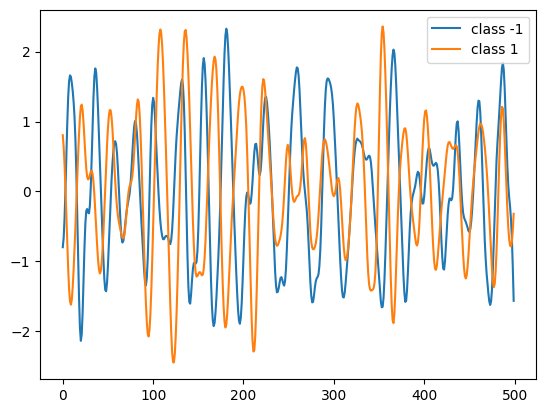

In [5]:
# check for all unique data classes and plot a sample of 1 positive waveform, and one negative one.
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

print(f'unique classes: {classes}')
plt.figure()
for c in classes:
    c_X_train = X_train[y_train == c]
    plt.plot(c_X_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

The blue waveform shows an instance of an asymptomatic diagnostic. The orange indicates the symptom was present. And there ar indeed only two unique classes in the y dataset.

The data is univariate, but requires reshapping to be used in a CNN, RNN, LSTM etc. The current shape is (3601, 500), and need to be (3601, 500, 1) in order to be used in the models. Also if multivariate data from a function or transform is required to acompany the raw data, this will alow each datapoint to be acompanied by other calculations. 

In [6]:
# Reshape the univariate data to resemble multivariate, and enable extra channels for other transformed data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(f'X_train shape: {X_train.shape} X_test shape:{X_test.shape}')

X_train shape: (3601, 500, 1) X_test shape:(1320, 500, 1)


One of the code examples I am refrencing is suggesting to normalize the y data to 1 and 0, and uses a softmax on the output layer. I think I will try leaving the data as 1, -1 and using a tanh on the output layer to see if I get similar results with an activation function I think it will be better with binary classification. It also shuffles the X train data, but I am tempted to try something different. I think I will preserve the original data for final testing of the model, and create a simple method to shuffle and resplit the data stratified, in between smaller blocks of epochs to see if I can't prevent overfitting that way.  

**Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions (65 points)**

Start the main analysis (the main analysis refers to supervised learning tasks such as classification or regression). Depending on your project, you may have one model or more. Generally, it is deemed a higher quality project if you compare multiple models and show your understanding of why specific models work better than the other or what limitations or cautions specific models may have. For machine learning models, another recommendation is to show enough effort on the hyperparameter optimization.

 If your project involves making a web app (not required), you can include the demo.

To start with I am going to build a simple model with a couple conv layers, a couple regularization, and pooling layers, followed by a dense hidden layer, and a single output neuron with a tanh function. After some research I found that the model will need to have certain hyperparameters changed to suit the data. For started the metric will need to be binary accuracy with a threshold of 0, and the loss will need to be mean squared error.  

In [39]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from keras.metrics import BinaryAccuracy

# start with a simple sequential base model
cnn_model = Sequential()

# Add an input layer
cnn_model.add(Input(X_train.shape[1:]))

# Add 2 convolution layers with pooling and dropout
cnn_model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.25))

# add a global average pooling layer and dense hidden layer
cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))

# final layer 1 neuron with tanh function for -1 to 1 output
cnn_model.add(Dense(1, activation='tanh'))

# compile with adam optimizer and MSE loss, accuracy for the metric
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['Accuracy'])

cnn_model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 496, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 248, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 248, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 244, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 122, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 122, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,945 (74.00 KB)

 Trainable params: 18,945 (74.00 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Fit the model and save the history
cnn_history = cnn_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    verbose=2
)

Epoch 1/10
90/90 - 5s - 54ms/step - Accuracy: 0.0000e+00 - loss: 0.9924 - val_Accuracy: 0.0000e+00 - val_loss: 0.9643
Epoch 2/10
90/90 - 0s - 5ms/step - Accuracy: 0.0000e+00 - loss: 0.8645 - val_Accuracy: 0.0000e+00 - val_loss: 0.7760
Epoch 3/10
90/90 - 0s - 5ms/step - Accuracy: 0.0257 - loss: 0.7492 - val_Accuracy: 0.0014 - val_loss: 0.7243
Epoch 4/10
90/90 - 0s - 5ms/step - Accuracy: 0.1149 - loss: 0.6176 - val_Accuracy: 0.2455 - val_loss: 0.5839
Epoch 5/10
90/90 - 0s - 5ms/step - Accuracy: 0.2181 - loss: 0.5491 - val_Accuracy: 0.1401 - val_loss: 0.5172
Epoch 6/10
90/90 - 0s - 5ms/step - Accuracy: 0.2396 - loss: 0.5102 - val_Accuracy: 0.3121 - val_loss: 0.4801
Epoch 7/10
90/90 - 0s - 5ms/step - Accuracy: 0.2878 - loss: 0.4585 - val_Accuracy: 0.1678 - val_loss: 0.5187
Epoch 8/10
90/90 - 0s - 5ms/step - Accuracy: 0.2899 - loss: 0.4340 - val_Accuracy: 0.3412 - val_loss: 0.4560
Epoch 9/10
90/90 - 0s - 5ms/step - Accuracy: 0.3181 - loss: 0.3915 - val_Accuracy: 0.3717 - val_loss: 0.4562
Ep

Results are far and away much lower than I was hoping. I will attempt to increase the complexity of the model to adress the underfitting, and see if that will help to solve the issue. If not I may need to rethink my attempt to keep the y data as 1, -1. 

In [9]:
# Rework the model with an extra convolution layer, and an extra hidden dense layer
cnn_model = Sequential()

cnn_model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=X_train.shape[1:]))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.25))

cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(1, activation='tanh'))

cnn_model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(
    reduction="sum_over_batch_size"), metrics=['Accuracy'])

cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 496, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 248, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 248, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 244, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 122, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 122, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 118, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 59, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 59, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,737 (331.00 KB)

 Trainable params: 84,737 (331.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# fit and history
cnn_history = cnn_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    verbose=2
)

Epoch 1/100
90/90 - 7s - 83ms/step - Accuracy: 0.0000e+00 - loss: 1.0018 - val_Accuracy: 0.0000e+00 - val_loss: 0.9747
Epoch 2/100
90/90 - 0s - 5ms/step - Accuracy: 0.0080 - loss: 0.8531 - val_Accuracy: 0.0042 - val_loss: 0.7013
Epoch 3/100
90/90 - 0s - 5ms/step - Accuracy: 0.1983 - loss: 0.5859 - val_Accuracy: 0.2247 - val_loss: 0.4069
Epoch 4/100
90/90 - 0s - 5ms/step - Accuracy: 0.3521 - loss: 0.3495 - val_Accuracy: 0.4327 - val_loss: 0.2949
Epoch 5/100
90/90 - 0s - 5ms/step - Accuracy: 0.3872 - loss: 0.3139 - val_Accuracy: 0.4327 - val_loss: 0.2957
Epoch 6/100
90/90 - 0s - 5ms/step - Accuracy: 0.4014 - loss: 0.2814 - val_Accuracy: 0.4549 - val_loss: 0.3675
Epoch 7/100
90/90 - 0s - 5ms/step - Accuracy: 0.4003 - loss: 0.2875 - val_Accuracy: 0.3897 - val_loss: 0.2416
Epoch 8/100
90/90 - 0s - 5ms/step - Accuracy: 0.4042 - loss: 0.2745 - val_Accuracy: 0.4591 - val_loss: 0.4165
Epoch 9/100
90/90 - 0s - 5ms/step - Accuracy: 0.4066 - loss: 0.2650 - val_Accuracy: 0.4189 - val_loss: 0.2244
E

I've added another convolution layer to the model, will see if the accuracy improves at all.

I thought I had lost this one, but upon using my trained model I originally got around the same accuracy. about 47-48%. But I noticed the predictions were coming out in the shape of (1320, 1) since each of the values were contained in ttheir own array, the mean was not working correctly. I will attempt to see if I am having the same issue in the binary accuracy metric causing it to provide inacurate scores durring the training. 

In [11]:
preds = cnn_model.predict(X_test)
normal_preds = np.where(preds > 0, 1, -1) 
print(y_test)
print(normal_preds)
print(f'yhat shape: {normal_preds.shape}')
accuracy = np.mean(y_test == normal_preds)
print(f'Accuracy before flattening:{accuracy}')
normal_preds = normal_preds.flatten()
accuracy = np.mean(y_test == normal_preds)
print(f'Accuracy after flattening:{accuracy}')


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[-1 -1 -1 ...  1  1  1]
[[-1]
 [-1]
 [-1]
 ...
 [ 1]
 [ 1]
 [ 1]]
yhat shape: (1320, 1)
Accuracy before flattening:0.4993250688705234
Accuracy after flattening:0.9340909090909091


Changing the accuracy metric does not help much, after some research it apears the accuracy functions only realy work with 0, 1 normalized data. 

After playing with the loss funtions, trying huber, and a few others I am getting very similar results to the MSE. The actual accuracy of the predictions are pretty good at around 94% accuracy after 100 epochs, though the model seems to stagnate at that level. I think this is a pretty good result, and will continue by normalizing the y_data, and trying one of the more modern loss functions and accuracy metrics. But problem aside I did learn that the MSE loss function will still work when a target class is 1, -1.

In [12]:
# Normalize the y data to 0 and 1
y_train_normal = np.where(y_train > 0, 1, 0)
print(y_train_normal)
y_test_normal = np.where(y_test > 0, 1, 0)
print(y_test_normal)

[0 1 0 ... 0 1 0]
[0 0 0 ... 1 1 1]


In [41]:
cnn_model = Sequential()

cnn_model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=X_train.shape[1:]))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.25))

cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(1, activation='sigmoid'))


cnn_model.compile(optimizer=keras.optimizers.AdamW(
    learning_rate=0.001,
    weight_decay=0.004), 
    loss='BinaryCrossentropy', 
    metrics=['BinaryAccuracy'],
    
)

cnn_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 496, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 248, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 248, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 244, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 122, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 122, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 118, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 59, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 59, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,249 (395.50 KB)

 Trainable params: 101,249 (395.50 KB)

 Non-trainable params: 0 (0.00 B)

Adding some callbacks as well to the new sgmoid 0 and 1 binary model to imrpove accuracy, save best model only, early stopping, and reduceLR on plateu.

In [42]:
# Add callbacks to stop early, reduce learningrate and save best model only.
callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5),
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
]

In [43]:
# Fit the new model with callbacks and plot history with new accurate metrics
cnn_history = cnn_model.fit(
    X_train,
    y_train_normal,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test_normal),
    verbose=2,
    callbacks=callbacks
)

Epoch 1/100
113/113 - 12s - 105ms/step - BinaryAccuracy: 0.5018 - loss: 0.6953 - val_BinaryAccuracy: 0.4932 - val_loss: 0.6880 - learning_rate: 0.0010
Epoch 2/100
113/113 - 1s - 6ms/step - BinaryAccuracy: 0.6115 - loss: 0.6103 - val_BinaryAccuracy: 0.6924 - val_loss: 0.5391 - learning_rate: 0.0010
Epoch 3/100
113/113 - 1s - 6ms/step - BinaryAccuracy: 0.7151 - loss: 0.5165 - val_BinaryAccuracy: 0.8553 - val_loss: 0.3412 - learning_rate: 0.0010
Epoch 4/100
113/113 - 1s - 6ms/step - BinaryAccuracy: 0.8350 - loss: 0.3538 - val_BinaryAccuracy: 0.9136 - val_loss: 0.2484 - learning_rate: 0.0010
Epoch 5/100
113/113 - 1s - 6ms/step - BinaryAccuracy: 0.8892 - loss: 0.2697 - val_BinaryAccuracy: 0.9076 - val_loss: 0.2397 - learning_rate: 0.0010
Epoch 6/100
113/113 - 1s - 6ms/step - BinaryAccuracy: 0.8992 - loss: 0.2499 - val_BinaryAccuracy: 0.9121 - val_loss: 0.2317 - learning_rate: 0.0010
Epoch 7/100
113/113 - 1s - 6ms/step - BinaryAccuracy: 0.9153 - loss: 0.2388 - val_BinaryAccuracy: 0.9242 - va

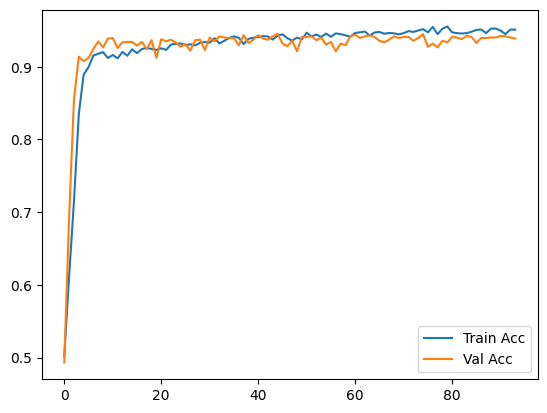

In [44]:
# plot the accuracy history from the training session
plt.plot(cnn_history.history['BinaryAccuracy'], label='Train Acc')
plt.plot(cnn_history.history['val_BinaryAccuracy'], label='Val Acc')
plt.legend()
plt.show()

As you can see, the results are very similar to the model I built using the mean square error, and working with the raw y values. The model seems to max out areound 94%, and is pretty stable. I am happy with this result, but need to move on in order to try a couple other models. I think there are a few things I could do to improve upon the outcome, but at around 95% accuracy, I don't see the point. So next I will try to get a transformer up adn running, to see how it compares. 

**Transformer**
After some research I realized how complicated a good transformer can be to implement with positional encoders and the like. As such I am going to try and load a pretrained transformer from the keras hub, fit and fine tune it, and see if I can get a reasonable result. The model I will be using is the whisper classifier. It is normaly used for speach recognition, It is my hope that the waveforms in the dataset could be considered similar to speech, and the model will be able to differentiate between the two classes.

In [24]:
def build_whisper_classifier(preset="whisper_tiny_en"):
    # Load preprocessor for raw audio to Mel spectrograms
    preprocessor = keras_hub.layers.WhisperAudioConverter.from_preset(preset)
    
    # Load the Whisper backbone
    backbone = keras_hub.models.WhisperBackbone.from_preset(preset)
    
    # Input: Raw audio waveforms (your shape: (batch, 500, 1))
    inputs = Input(shape=(500, 1))
    
    # Squeeze channel dim if univariate (to (batch, 500))
    squeezed_inputs = Lambda(lambda x: tf.squeeze(x, axis=-1))(inputs)
    
    # Preprocess to Mel features (output shape: (batch, seq_len, 80))
    mel_features = preprocessor(squeezed_inputs)
    
    # Create dummy decoder inputs to handle symbolic tensors
    dummy_token_ids = Lambda(lambda f: tf.zeros((tf.shape(f)[0], 1), dtype=tf.int32))(mel_features)
    dummy_padding_mask = Lambda(lambda f: tf.ones((tf.shape(f)[0], 1), dtype=tf.float32))(mel_features)  
    
    # Call the backbone with required inputs
    outputs = backbone({
        "encoder_features": mel_features,
        "decoder_token_ids": dummy_token_ids,
        "decoder_padding_mask": dummy_padding_mask
    })
    
    # Extract the encoder sequence output
    x = outputs["encoder_sequence_output"]
    
    # Classification head
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Freeze backbone
    backbone.trainable = False

    # Compile the model
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['BinaryAccuracy'],
    jit_compile=False  # Disable XLA JIT to avoid unsupported op errors
    )
    return model

After trying to load the model simply, I had many many errors to work through. The troubleshooting alone took up an entire day. After finally getting the dummy inputs to work, and squeezing the input to match the expected input, I was able to get it to compile. 


In [25]:
# Build the whisper model
whisper_model = build_whisper_classifier()
whisper_model.summary()

Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 500, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 500)       │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ whisper_audio_conv… │ (None, 3000, 80)  │          0 │ lambda_3[0][0]    │
│ (WhisperAudioConve… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 1)         │          0 │ whisper_audio_co… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1)         │          0 │ whisper_audio_co… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ whisper_backbone    │ [(None, 1, 384),  │ 37,760,256 │ lambda_5[0][0],   │
│ (WhisperBackbone)   │ (None, 1500,      │            │ lambda_4[0][0],   │
│                     │ 384)]             │            │ whisper_audio_co… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ whisper_backbone… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     49,280 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 128)       │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │        129 │ dropout_57[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,809,665 (144.23 MB)

 Trainable params: 49,409 (193.00 KB)

 Non-trainable params: 37,760,256 (144.04 MB)

The initial run with the CPU was shaping up to be over 30 mins per epoch, so I tried to get it to run initially on the TPU VM 3-8, this proved fruitless. Even when I did get it to load the TPU, and created a build specifiaclly for it. The tpu would lock up, and the enviroment would restart. Ultimately I had to run it on a P100 with XLA JIT disabled to get it to work even on that.

In [26]:
# Fit the model with callbacks and save the training history
whisper_history = whisper_model.fit(
    X_train, y_train_normal,
    validation_data=(X_test, y_test_normal),
    epochs=50, 
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 549ms/step - BinaryAccuracy: 0.5498 - loss: 0.7352 - val_BinaryAccuracy: 0.6530 - val_loss: 0.6350 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 526ms/step - BinaryAccuracy: 0.6804 - loss: 0.6216 - val_BinaryAccuracy: 0.7114 - val_loss: 0.5845 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 527ms/step - BinaryAccuracy: 0.7149 - loss: 0.5799 - val_BinaryAccuracy: 0.7485 - val_loss: 0.5345 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 526ms/step - BinaryAccuracy: 0.7440 - loss: 0.5335 - val_BinaryAccuracy: 0.8311 - val_loss: 0.4637 - learning_rate: 0.0010
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 527ms/step - BinaryAccuracy: 0.7845 - loss: 0.4856 - val_BinaryAccuracy: 0.8417 - val_loss: 0.4350 - learning_rate: 0.0010
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 526ms/step - BinaryAccuracy: 0.7826 - loss: 0.4744 - val_BinaryAccuracy: 0.8394 - val_loss: 0.4083 - learning_rate: 0.001

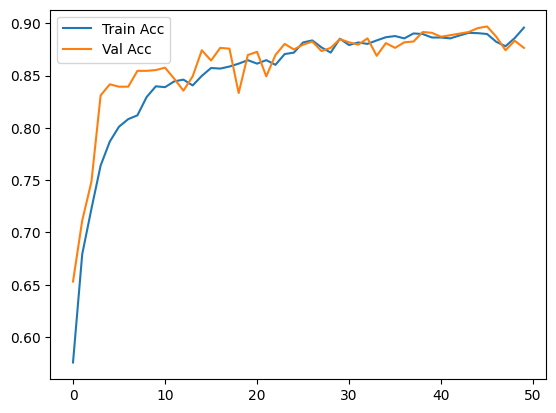

In [28]:
# create a plot from the training history
plt.plot(whisper_history.history['BinaryAccuracy'], label='Train Acc')
plt.plot(whisper_history.history['val_BinaryAccuracy'], label='Val Acc')
plt.legend()
plt.show()

After a couple of tweaks, and running on the P100, epoch time dropped from half an hour on the CPU to 60s on the P100. I was suprised at how quickly the model adapted, and while not exactly impressed with the overall performance compared to the CNN. I was suprised that it was able to function at all, and did suprisingly well wiith the backbone parameters frozen. I am happy with the results, and may use pretrained models in the future, though I will likely try easier to implement methods first.

Next I will attempt a thrid and final model. For this model, I have decided to try a hybrid model combining a convolutional network (CNN) frontend, and a long term short term (LSTM) hidden layer. I think II should get good results, and hopefully the training time is much less than the transformer.

In [30]:
# build a new CNN / LSTM hybrid
def build_cnn_lstm_model(input_shape=(500, 1)):
    model = Sequential()
    
    # CNN feature extraction
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    # LSTM
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    
    # Classifier
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adamW', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [31]:
hybrid_model = build_cnn_lstm_model()
hybrid_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 496, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 496, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 244, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 244, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 122, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 122, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 118, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 118, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 59, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 59, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 59, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 59, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 585,729 (2.23 MB)

 Trainable params: 584,833 (2.23 MB)

 Non-trainable params: 896 (3.50 KB)

In [32]:
hybrid_history = hybrid_model.fit(X_train, y_train_normal, validation_data=(X_test, y_test_normal), epochs=500, batch_size=32, callbacks=callbacks)

Epoch 1/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.5908 - loss: 0.6436 - val_accuracy: 0.5159 - val_loss: 0.7857 - learning_rate: 0.0010
Epoch 2/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8549 - loss: 0.3602 - val_accuracy: 0.5273 - val_loss: 0.7037 - learning_rate: 0.0010
Epoch 3/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8677 - loss: 0.3262 - val_accuracy: 0.6083 - val_loss: 1.0161 - learning_rate: 0.0010
Epoch 4/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8911 - loss: 0.2804 - val_accuracy: 0.7318 - val_loss: 0.5041 - learning_rate: 0.0010
Epoch 5/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8868 - loss: 0.2879 - val_accuracy: 0.9000 - val_loss: 0.2293 - learning_rate: 0.0010
Epoch 6/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9111 - loss: 0.2371 - val_accuracy: 0.9000 - val_loss: 0.2366 - learning_rate: 0.0010
Epoch 7/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9271 - 

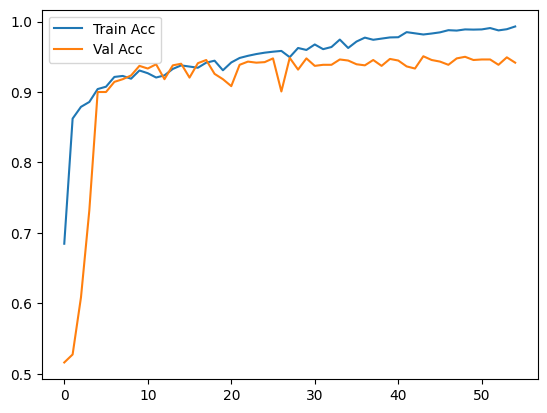

In [35]:
# plot the accuracy history from the training session
plt.plot(hybrid_history.history['accuracy'], label='Train Acc')
plt.plot(hybrid_history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

The hybrid model did not improve on the overal testing accuracy. There was a little overfitting, and validation accuracy is right around 95% with a few percent divergence toward the end of the training. It did stop out early, maxing at the 55 epoch mark. I do suspect with some more tweaking this model could do slightly better, maybey beating the 95% accuracy ceiling. The training time on a P100 was only a matter of minutes, and I would wager either the traditional CNN, or the hybrid model would run well in an edge computing capacity. So if this were a model that needed to run on say a small diagnostic machine, or even in a car engine control module, either would do well.  

**Conclusions:**

I found that the CNN and hybrid models were very effective, easy to build, and fast to train. I found working with non-standard data like the 1 and -1 values in the original y data did work to some extent, but made the keras package hard to work with, and did not improve on the outcome. The pretrained transformer was a royal pain to get working, slow to train, and not as accurate as the other models. It was however interesting that a model normaly used for speach recognition was able to function at all in this capacity and be suprisingly accurate. I also learned alot by implementing and troubleshooting it. I think one of the main reasons it did not do as well as the others is that it was created for large multiclass classification, and using it for binary classification it doesn't quite mesh. I will validate the models now to get an overall performance comparison.  

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X_test, y_test_normal, model_name):
    # Predictions (threshold 0.5 for binary)
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_true = y_test.flatten()  # Assuming y_test_norm is (samples,)
    
    # Metrics
    loss, acc = model.evaluate(X_test, y_test_normal)
    auc = roc_auc_score(y_true, y_pred_prob)
    
    print(f'{model_name} Test Metrics:')
    print(f'Loss: {loss:.4f}, Accuracy: {acc:.4f}')
    print(f'ROC-AUC: {auc:.4f}')

# Evaluate each
evaluate_model(cnn_model, X_test, y_test_normal, 'CNN')
evaluate_model(whisper_model, X_test, y_test_normal, 'Whisper')
evaluate_model(hybrid_model, X_test, y_test_normal, 'Hybrid')

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - BinaryAccuracy: 0.9543 - loss: 0.1370
CNN Test Metrics:
Loss: 0.1651, Accuracy: 0.9432
ROC-AUC: 0.9832
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 377ms/step - BinaryAccuracy: 0.9080 - loss: 0.2398
Whisper Test Metrics:
Loss: 0.2521, Accuracy: 0.8917
ROC-AUC: 0.9633
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9503 - loss: 0.1339
Hybrid Test Metrics:
Loss: 0.1484, Accuracy: 0.9424
ROC-AUC: 0.9870


All metrics seem to line up with the training data, I am happy with the results. 

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

    Negative       0.97      0.92      0.94       681
    Positive       0.92      0.97      0.94       639

    accuracy                           0.94      1320
   macro avg       0.94      0.94      0.94      1320
weighted avg       0.94      0.94      0.94      1320



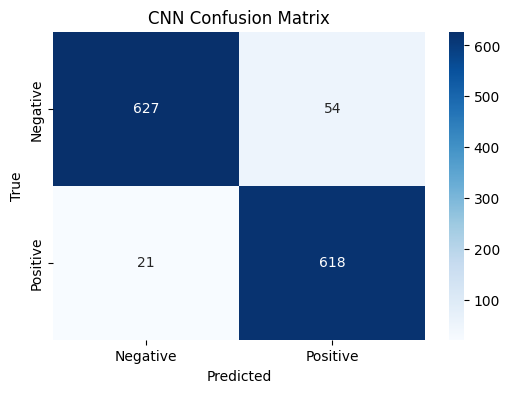

42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step
              precision    recall  f1-score   support

    Negative       0.92      0.86      0.89       681
    Positive       0.86      0.92      0.89       639

    accuracy                           0.89      1320
   macro avg       0.89      0.89      0.89      1320
weighted avg       0.89      0.89      0.89      1320



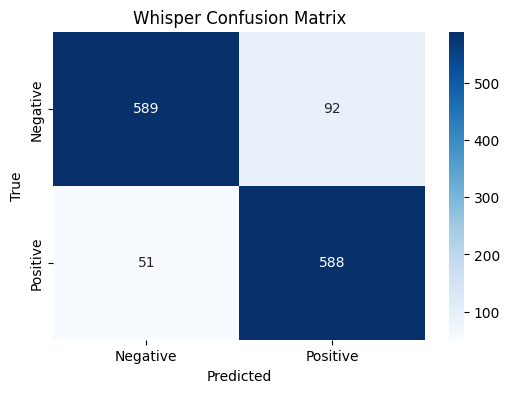

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

    Negative       0.94      0.95      0.94       681
    Positive       0.94      0.94      0.94       639

    accuracy                           0.94      1320
   macro avg       0.94      0.94      0.94      1320
weighted avg       0.94      0.94      0.94      1320



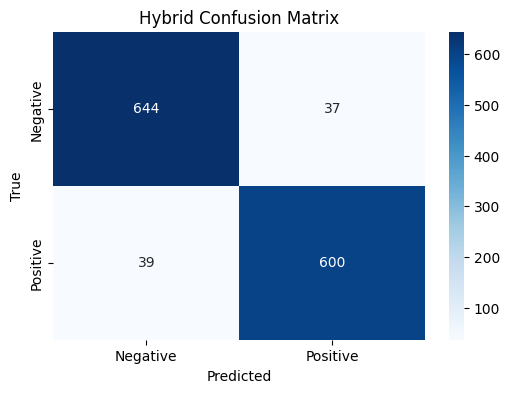

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test_normal, model_name):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_true = y_test_normal.flatten()
    
    # Report
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))
    
    # Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# For each model
plot_confusion_matrix(cnn_model, X_test, y_test_normal, 'CNN')
plot_confusion_matrix(whisper_model, X_test, y_test_normal, 'Whisper')
plot_confusion_matrix(hybrid_model, X_test, y_test_normal, 'Hybrid')

Confusion matrices show clearly the majority of predictions are correct. I do find it interesting the difference between the false positive to false negative are much higher on the whisper model.

Overall I am happy with how this project turned out, and did learn quite a few things through experimenting and troubleshooting. Thank you for reading.

**References**

Keras Team. (n.d.). Timeseries classification from scratch. Keras. Retrieved July 29, 2025, from https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

Keras Team. (n.d.). Timeseries classification with a Transformer model. Keras. Retrieved July 29, 2025, from https://keras.io/examples/timeseries/timeseries_classification_transformer/

Timeseriesclassification.com. (n.d.). FordA dataset description. Retrieved July 29, 2025, from https://timeseriesclassification.com/description.php?Dataset=Forda

UCR Machine Learning Group. (2018). UCR time series classification archive. University of California, Riverside. Retrieved July 29, 2025, from https://www.cs.ucr.edu/~eamonn/time_series_data_2018/

xAI. (2025). Grok: An AI assistant for answering user queries and providing code assistance. xAI. Retrieved July 29, 2025, from https://x.ai/grok